In [15]:
# ============================================
# SETUP - YOUR EXACT PATHS
# ============================================
import itertools
import json
import os
from collections.abc import Callable, Sequence
from enum import Enum, auto
from functools import wraps
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import datasets, models, transforms
from torchvision.models.resnet import ResNet
from tqdm import tqdm

# YOUR CONFIRMED PATHS
MODEL_PATH = "person_a_baseline/results/model_weights/resnet18_baseline.pth"
DATA_PATH = "data/"

print(f"✅ Model path: {MODEL_PATH}")
print(f"✅ Data path: {DATA_PATH}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Using device: {device}")

✅ Model path: person_a_baseline/results/model_weights/resnet18_baseline.pth
✅ Data path: data/
📱 Using device: cpu


In [3]:
# ============================================
# LOAD THE SAVED MODEL
# ============================================

# Create model architecture
def create_model(
	num_classes=102, model_init: ResNet = models.resnet18, weights: str | None = None
):  # type: ignore
	"""Recreate the ResNet18 model architecture"""
	model = model_init(weights=weights)  # No pretrained weights needed
	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, num_classes)
	return model


# Initialize and load model
model = create_model(num_classes=102)
try:
	if os.path.exists(MODEL_PATH):
		model_state = torch.load(MODEL_PATH, map_location=device)
		model.load_state_dict(model_state)
		model = model.to(device)
		model.eval()
		print(f"✅ Model loaded successfully from: {MODEL_PATH}")
	else:
		print(f"❌ Model file not found at: {MODEL_PATH}")
		print(
			"Please update the model_path variable with the correct path to your saved model."
		)
except Exception as e:
	print(f"Error loading model: {e}")
	print("Make sure the model file exists and the path is correct.")

✅ Model loaded successfully from: person_a_baseline/results/model_weights/resnet18_baseline.pth


In [4]:
# ============================================
# LOAD EXISTING DATASET - NO DOWNLOAD
# ============================================


def get_data_transforms():
	"""Get data transforms for evaluation"""

	# ImageNet dataset’s mean and standard deviation
	normalize = transforms.Normalize(
		mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
	)

	test_transform = transforms.Compose(
		[
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			normalize,
		]
	)

	return test_transform


# Load datasets from your existing data path
test_transform = get_data_transforms()

# IMPORTANT: download=False since data already exists
train_dataset = datasets.Flowers102(
	root=DATA_PATH,
	split="train",
	transform=test_transform,
	download=False,  # DO NOT DOWNLOAD - USE EXISTING
)

val_dataset = datasets.Flowers102(
	root=DATA_PATH,
	split="val",
	transform=test_transform,
	download=False,  # DO NOT DOWNLOAD - USE EXISTING
)

test_dataset = datasets.Flowers102(
	root=DATA_PATH,
	split="test",
	transform=test_transform,
	download=False,  # DO NOT DOWNLOAD - USE EXISTING
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
	train_dataset, batch_size=32, shuffle=False, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
	val_dataset, batch_size=32, shuffle=False, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
	test_dataset, batch_size=32, shuffle=False, num_workers=0
)

print("✅ Data loaded from existing path!")
print("📊 Dataset sizes:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

✅ Data loaded from existing path!
📊 Dataset sizes:
  Training: 1020 samples
  Validation: 1020 samples
  Test: 6149 samples


In [5]:
# ============================================
# MODEL STATISTICS
# ============================================


def count_parameters(model):
	"""Count model parameters"""
	total = sum(p.numel() for p in model.parameters())
	trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
	return total, trainable


total_params, trainable_params = count_parameters(model)

print("=" * 70)
print("MODEL ARCHITECTURE STATISTICS")
print("=" * 70)
print("Model: ResNet18 (Modified for 102 classes)")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size (MB): {total_params * 4 / 1024 / 1024:.2f}")
print("Input Size: 3 × 224 × 224")
print("Output Classes: 102")

MODEL ARCHITECTURE STATISTICS
Model: ResNet18 (Modified for 102 classes)
Total Parameters: 11,228,838
Trainable Parameters: 11,228,838
Model Size (MB): 42.83
Input Size: 3 × 224 × 224
Output Classes: 102


In [6]:
# ============================================
# EVALUATION FUNCTION
# ============================================


@torch.no_grad()
def evaluate_model(model, dataloader, device, desc="Evaluating"):
	"""Evaluate model on a dataset"""
	model.eval()

	all_predictions = []
	all_labels = []
	all_probs = []
	total_loss = 0
	criterion = nn.CrossEntropyLoss()

	for images, labels in tqdm(dataloader, desc=desc):
		images = images.to(device)
		labels = labels.to(device)

		outputs = model(images)
		loss = criterion(outputs, labels)
		total_loss += loss.item()

		probs = torch.softmax(outputs, dim=1)
		_, preds = torch.max(outputs, 1)

		all_predictions.extend(preds.cpu().numpy())
		all_labels.extend(labels.cpu().numpy())
		all_probs.extend(probs.cpu().numpy())

	predictions = np.array(all_predictions)
	labels = np.array(all_labels)
	probabilities = np.array(all_probs)

	accuracy = 100.0 * (predictions == labels).sum() / len(labels)
	avg_loss = total_loss / len(dataloader)

	return {
		"predictions": predictions,
		"labels": labels,
		"probabilities": probabilities,
		"accuracy": accuracy,
		"loss": avg_loss,
	}

In [7]:
# ============================================
# EVALUATE ON ALL DATASETS
# ============================================

print("=" * 70)
print("EVALUATING MODEL PERFORMANCE")
print("=" * 70)

# Evaluate on all three sets
train_results = evaluate_model(model, train_loader, device, "Training Set")
val_results = evaluate_model(model, val_loader, device, "Validation Set")
test_results = evaluate_model(model, test_loader, device, "Test Set")

# Display results
print("\n" + "=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)
print(f"📊 Training Accuracy:   {train_results['accuracy']:.2f}%")
print(f"📊 Validation Accuracy: {val_results['accuracy']:.2f}%")
print(f"📊 Test Accuracy:       {test_results['accuracy']:.2f}%")
print(
	f"\n⚠️ Overfitting Gap (Train-Test): {train_results['accuracy'] - test_results['accuracy']:.2f}%"
)

EVALUATING MODEL PERFORMANCE


Test Set: 100%|██████████| 193/193 [02:39<00:00,  1.21it/s]


PERFORMANCE SUMMARY
📊 Training Accuracy:   99.90%
📊 Validation Accuracy: 82.55%
📊 Test Accuracy:       79.67%

⚠️ Overfitting Gap (Train-Test): 20.23%


In [8]:
def show_first_image_of_class(dataset, class_id, class_name):
	# Find first image index for the class
	idx = next(i for i, lbl in enumerate(dataset._labels) if lbl == class_id)

	# Load image from file
	img_path = dataset._image_files[idx]
	img = Image.open(img_path).convert("RGB")

	# Apply dataset transform if any
	if dataset.transform is not None:
		# To visualize, we want the *untransformed* version (so skip normalization)
		# comment out below line if you want to visualize the transformed tensor
		pass

	plt.imshow(img)
	plt.title(f"{class_name} (class {class_id})")
	plt.axis("off")
	plt.show()


ADVANCED METRICS (Test Set)
Top-1 Accuracy: 79.67%
Top-3 Accuracy: 90.42%
Top-5 Accuracy: 93.90%
Top-10 Accuracy: 96.85%

🎯 CONFIDENCE ANALYSIS:
  Average Confidence: 0.797
  Confidence when Correct: 0.878
  Confidence when Wrong: 0.480
  Confidence Gap: 0.398

🏆 TOP 5 BEST CLASSES:
  1. Class 7 (bird of paradise): 100.0%


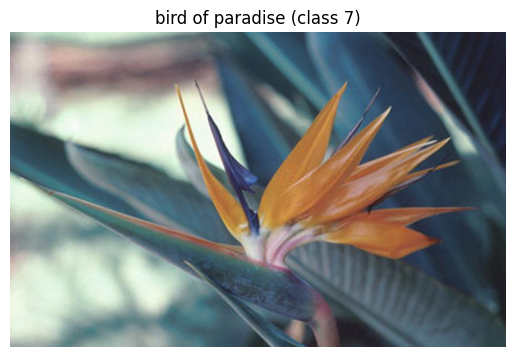

  2. Class 9 (globe thistle): 100.0%


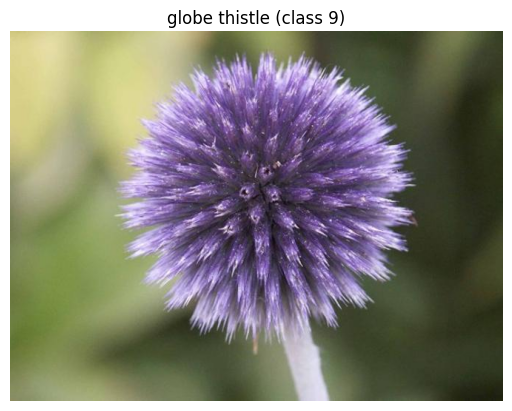

  3. Class 12 (king protea): 100.0%


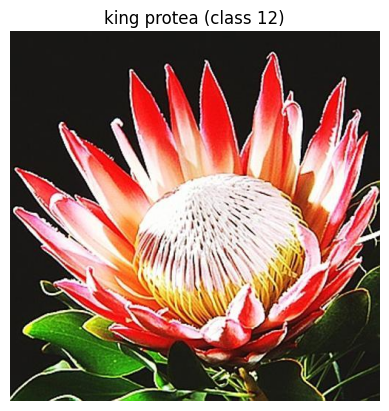

  4. Class 16 (purple coneflower): 100.0%


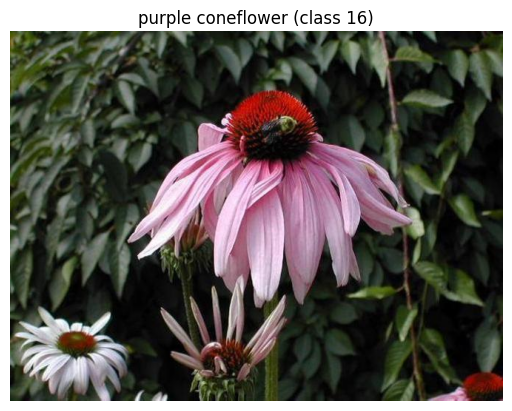

  5. Class 20 (fire lily): 100.0%


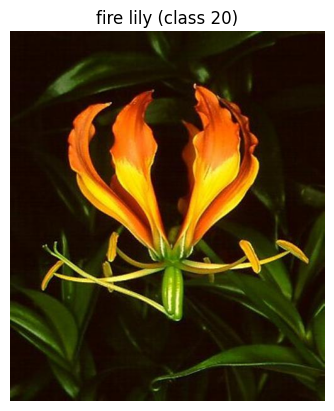


📉 TOP 5 WORST CLASSES:
  1. Class 89 (canna lily): 50.0%


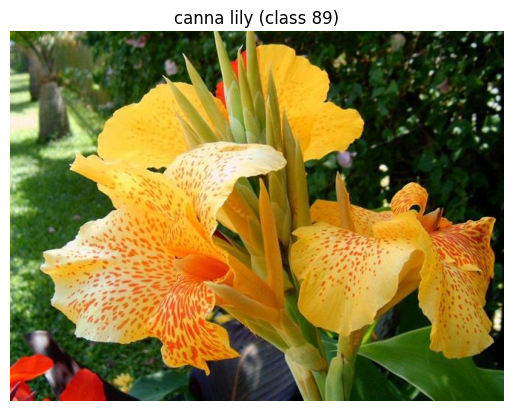

  2. Class 50 (petunia): 49.2%


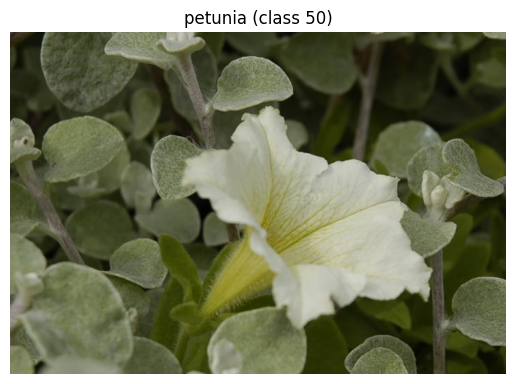

  3. Class 83 (columbine): 48.5%


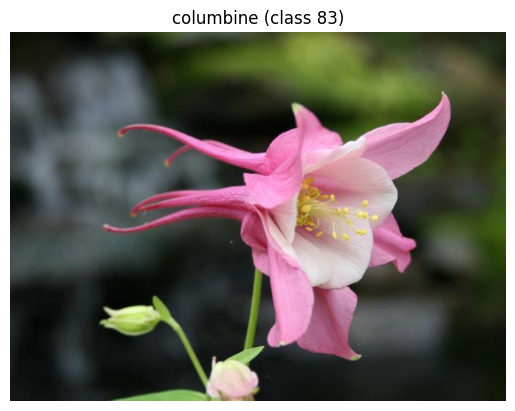

  4. Class 10 (snapdragon): 43.3%


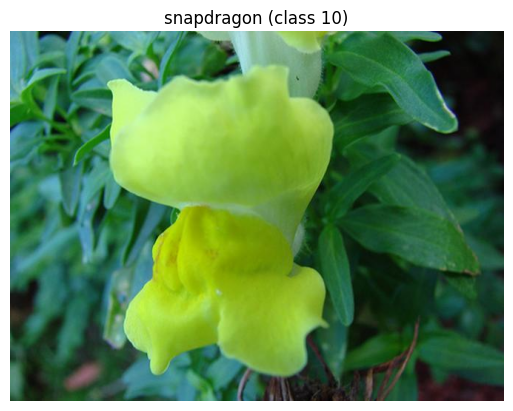

  5. Class 3 (sweet pea): 27.8%


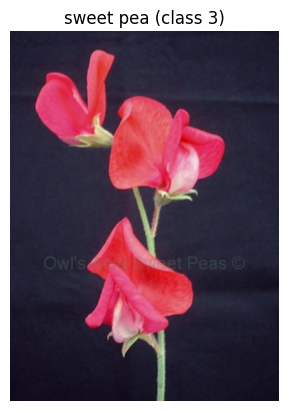

In [9]:
# ============================================
# ADVANCED METRICS
# ============================================


def calculate_topk_accuracy(probabilities, labels, k):
	"""Calculate top-k accuracy"""
	top_k_correct = 0
	for i in range(len(labels)):
		top_k_preds = np.argsort(probabilities[i])[-k:][::-1]
		if labels[i] in top_k_preds:
			top_k_correct += 1
	return 100.0 * top_k_correct / len(labels)


print("\n" + "=" * 70)
print("ADVANCED METRICS (Test Set)")
print("=" * 70)

# Top-K accuracies
topk_results = {}
for k in [1, 3, 5, 10]:
	topk_acc = calculate_topk_accuracy(
		test_results["probabilities"], test_results["labels"], k
	)
	topk_results[k] = topk_acc
	print(f"Top-{k} Accuracy: {topk_acc:.2f}%")

# Confidence analysis
predictions = test_results["predictions"]
labels = test_results["labels"]
probabilities = test_results["probabilities"]

confidence_scores = probabilities[np.arange(len(predictions)), predictions]
correct_mask = predictions == labels

avg_confidence = confidence_scores.mean()
avg_conf_correct = confidence_scores[correct_mask].mean()
avg_conf_wrong = confidence_scores[~correct_mask].mean()

print("\n🎯 CONFIDENCE ANALYSIS:")
print(f"  Average Confidence: {avg_confidence:.3f}")
print(f"  Confidence when Correct: {avg_conf_correct:.3f}")
print(f"  Confidence when Wrong: {avg_conf_wrong:.3f}")
print(f"  Confidence Gap: {avg_conf_correct - avg_conf_wrong:.3f}")

# Per-class accuracy
class_correct = {}
class_total = {}
for i in range(102):
	mask = labels == i
	if mask.sum() > 0:
		class_total[i] = mask.sum()
		class_correct[i] = (predictions[mask] == i).sum()

class_accuracies = [
	(i, 100.0 * class_correct[i] / class_total[i]) for i in class_correct.keys()
]
class_accuracies.sort(key=lambda x: x[1], reverse=True)

flower_classes = test_dataset.classes
print("\n🏆 TOP 5 BEST CLASSES:")
for i, (class_id, acc) in enumerate(class_accuracies[:5], 1):
	class_name = flower_classes[class_id]
	print(f"  {i}. Class {class_id} ({class_name}): {acc:.1f}%")
	show_first_image_of_class(test_dataset, class_id, class_name)

print("\n📉 TOP 5 WORST CLASSES:")
for i, (class_id, acc) in enumerate(class_accuracies[-5:], 1):
	class_name = flower_classes[class_id]
	print(f"  {i}. Class {class_id} ({class_name}): {acc:.1f}%")
	show_first_image_of_class(test_dataset, class_id, class_name)

# Part 2: Alternate Architectures

In [26]:
# === Model Setup ===
resnet_histories = {}

# Default list for full experiments
model_names_default = [
	"resnet18",
	"resnet34",
	"resnet50",
	"resnet101",
	# "resnet152", # doesn't fit in my machine's gpu
	"vit_base_patch32_224",
	"vit_base_patch16_224", # doesn't fit in my machine's gpu
]

# Smaller list for quick debugging
model_names_debug = [
	"resnet18",
	"resnet34",
	"vit_base_patch32_224",
]

In [43]:
class Mode(Enum):
	DEBUG_OVERWRITE = auto()  # short epochs, overwrite results
	FULL_OVERWRITE = auto()  # long epochs, overwrite results
	FULL_SKIP = auto()  # long epochs, skip existing results
	DEBUG_SKIP = auto()  # short epochs, skip existing results
	LOAD_ONLY = auto() # skip all training, load existing only


# TODO: Remember to run Mode.FULL_OVERWRITE then change default to LOAD_ONLY before handing in!
def get_or_compute_model_results(
	mode: Mode = Mode.DEBUG_SKIP,
	model_names: Optional[list[str]] = None,
	model_transforms: Sequence[Callable[[nn.Module], nn.Module] | None] = (),
	preserve_base_case: bool = True
) -> dict[str, dict[str, Any]]:
	"""
	Compute or load model results, supporting transformations and different modes.

	Args:
		mode (Mode):
			Specifies run behavior:
				- Mode.DEBUG_OVERWRITE: short epochs, overwrite results.
				- Mode.FULL_OVERWRITE: long epochs, overwrite results.
				- Mode.FULL_SKIP: long epochs, skip existing results.
				- Mode.DEBUG_SKIP: short epochs, skip existing results.

		model_names (Optional[list[str]]):
			List of model names to evaluate. If None, defaults are chosen
			based on the mode (debug vs full).

		model_transforms (Sequence[Optional[Callable[[nn.Module], nn.Module]]]):
			Functions applied to modify the model (e.g., pruning, deformable conv).
			Each transform must take an `nn.Module` and return an `nn.Module`.
			The untransformed model (None) is always included automatically.

		preserve_base_case (bool):
			if True, will not overwrite the base case without transforms, regardless of mode. 
			if False, base case without transforms will be treated the same as transformed cases

	Returns:
		dict[str, dict[str, Any]]:
			A mapping from `model_name` (including transform suffix) to its training
			history dictionary, including performance metrics and parameter count.
	"""

	# Ensure all transforms are distinct by name
	transform_names = [t.__name__ for t in model_transforms if t is not None]
	assert len(transform_names) == len(set(transform_names)), (
		"Duplicate model transform names detected. "
		f"Each transform must have a unique function name.\nTransform names:\n{transform_names}"
	)

	histories: dict[str, dict[str, Any]] = {}

	# Select default model names if not provided
	if model_names is None:
		if mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]:
			model_names = model_names_debug
		else:
			model_names = model_names_default
	else:
		# User explicitly provided models; assume full results are desired
		if mode not in (Mode.FULL_OVERWRITE, Mode.FULL_SKIP):
			mode = Mode.FULL_SKIP

	for model_name in model_names:
		for model_transform in itertools.chain(model_transforms, (None,)):
			transformed_model_name = (
				f"{model_name}_{model_transform.__name__}"
				if model_transform is not None
				else model_name
			)

			weights_dir = os.path.join("person_b_model_architecture","results", "model_weights", transformed_model_name)
			metrics_path = os.path.join("person_b_model_architecture", "results", f"metrics_{transformed_model_name}.json")
			os.makedirs(weights_dir, exist_ok=True)
			weights_path = os.path.join(weights_dir, f"{transformed_model_name}_best.pth")

			# Skip computation if results already exist
			# If mode is overwrite, dont skip computation unless preserve base case and processing base case
			if (
				os.path.exists(weights_path)
				and os.path.exists(metrics_path)
				and (mode not in [Mode.DEBUG_OVERWRITE, Mode.FULL_OVERWRITE] or (preserve_base_case and model_transform is None))
			):
				# print(f"Found existing results for '{transformed_model_name}', loading metrics...")
				with open(metrics_path, "r") as f:
					history = json.load(f)
				histories[transformed_model_name] = history
				continue
			
			elif mode == Mode.LOAD_ONLY:
				print(f"Performance for '{transformed_model_name}'not found. Skipping...")
				continue

			raise Exception(f"Performance for '{transformed_model_name}' not found at {weights_path}. Run person_b_model_architecture\\model_architecture.ipynb then try again")
			print(f"Computing performance for '{transformed_model_name}'...")
			short_run = mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]

			# Compute model performance
			model, history, num_params = get_performance( 
				model_name,
				num_epochs=2 if short_run else 30,
				model_transform=model_transform,
			)

			# Save model weights
			torch.save(model.state_dict(), weights_path)
			print(f"Model weights saved to {weights_path}")

			# Save metrics
			with open(metrics_path, "w") as f:
				json.dump(history, f, indent=4)
			print(f"Metrics saved to {metrics_path}")

			histories[transformed_model_name] = history

	# Save combined histories
	combined_path = os.path.join("person_b_model_architecture","results","all_histories.json")
	with open(combined_path, "w") as f:
		json.dump(histories, f, indent=4)
	print(f"All histories saved to {combined_path}")

	return histories

In [44]:
def plot_model_histories(histories: dict, save_dir: str = "person_b_model_architecture/results/plots", plot_save_name: str = ""):
	"""
	Plot validation accuracy per epoch and final test accuracy vs number of parameters.
	Also saves the plots as PNG files in `save_dir`.

	Args:
		histories: dict mapping transformed_model_name -> history dict.
		save_dir: directory path where plots are saved (default: "results/plots")
	"""
	os.makedirs(save_dir, exist_ok=True)

	# --- 1. Validation accuracy vs epoch ---
	plt.figure(figsize=(10, 6))
	for i, (transformed_model_name, h) in enumerate(histories.items(), start=1):
		val_acc_list = h.get("val_acc") or h.get("best_val_acc_list") or []
		if not val_acc_list:
			print(f"No validation accuracy found for {transformed_model_name}")
			continue

		label = f"{i}. {transformed_model_name}"
		plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label=label)
		plt.text(len(val_acc_list), val_acc_list[-1], str(i), fontsize=8, va="center", ha="left")

	plt.xlabel("Epoch")
	plt.ylabel("Validation Accuracy (%)")
	plt.title("Validation Accuracy vs Epoch")
	plt.legend(
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.05, 1),
	)
	plt.grid(True)
	plt.tight_layout()

	# filename creation
	val_filename = f"{plot_save_name}_validation_accuracy_vs_epoch.png" if plot_save_name else "validation_accuracy_vs_epoch.png"
	val_plot_path = os.path.join(save_dir, val_filename)

	plt.savefig(val_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {val_plot_path}")
	plt.show()

	# --- 2. Final test accuracy vs total parameters ---
	groups = {"resnet": [], "vit": [], "other": []}
	markers = {"resnet": "o", "vit": "s", "other": "^"}
	colors_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

	plt.figure(figsize=(10, 6))
	idx = 1

	for group in groups:
		group_colors = itertools.cycle(colors_list)
		for transformed_model_name, h in histories.items():
			test_acc = h.get("test_acc")
			num_params = h.get("num_params")
			if test_acc is None or num_params is None:
				continue

			name_lower = transformed_model_name.lower()
			model_group = (
				"vit" if "vit" in name_lower else "resnet" if "resnet" in name_lower else "other"
			)
			if model_group != group:
				continue

			color = next(group_colors)
			marker = markers[group]
			label = f"{idx}. {transformed_model_name}"
			plt.scatter(num_params, test_acc, label=label, color=color, marker=marker, s=80)
			plt.text(num_params, test_acc, str(idx), fontsize=8, va="bottom", ha="center")
			idx += 1

	plt.xscale("log")
	plt.xlabel("Total Parameters (log scale)")
	plt.ylabel("Test Accuracy (%)")
	plt.title("Test Accuracy vs Model Size")
	plt.legend(
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.05, 1),
	)
	plt.grid(True, which="both", ls="--", alpha=0.5)
	plt.tight_layout()

	# filename creation 
	test_filename = f"{plot_save_name}_test_accuracy_vs_model_size.png" if plot_save_name else "test_accuracy_vs_model_size.png"
	test_plot_path = os.path.join(save_dir, test_filename)

	plt.savefig(test_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {test_plot_path}")
	plt.show()



All histories saved to person_b_model_architecture\results\all_histories.json
Saved: person_b_model_architecture/results/plots\validation_accuracy_vs_epoch.png


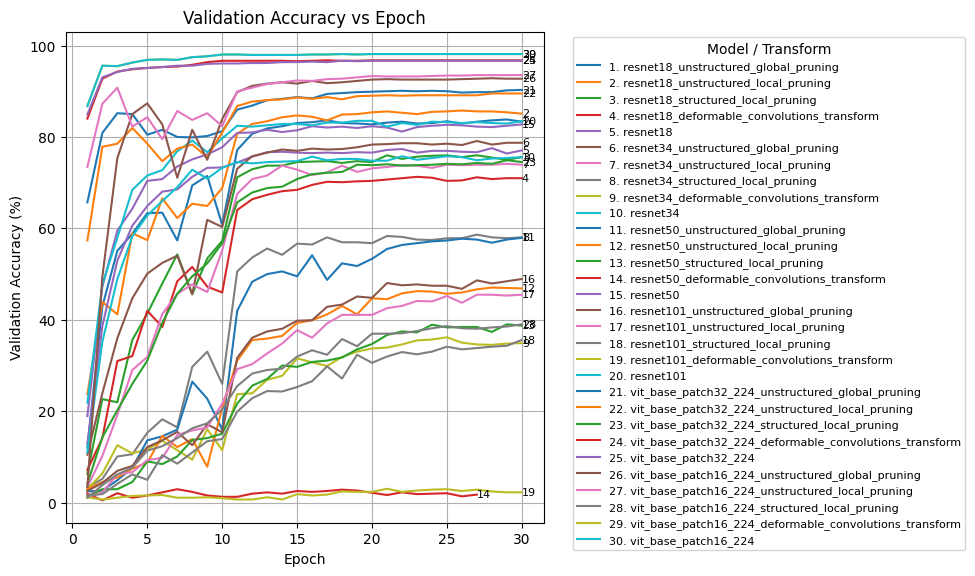

Saved: person_b_model_architecture/results/plots\test_accuracy_vs_model_size.png


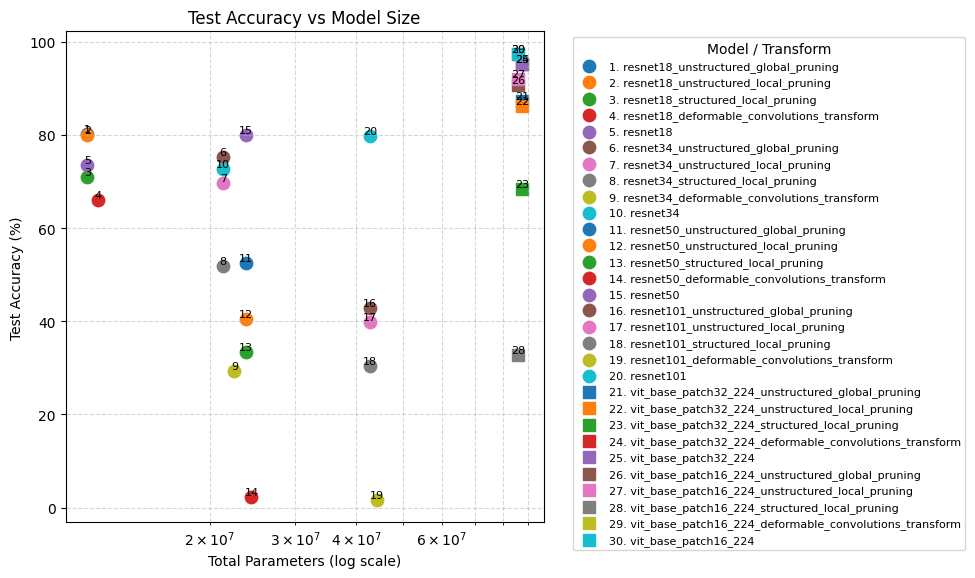

In [45]:
def placeholder_func(module: nn.Module) -> nn.Module:
    raise NotImplementedError("This is a placeholder function used to make get_or_compute results work. Run person_b_model_architecture\\model_architecture.ipynb to get the results")
    return nn.Module

def make_named_partial(base_func, name, **kwargs):
	@wraps(base_func)
	def wrapper(*args, **more_kwargs):
		return base_func(*args, **kwargs, **more_kwargs)
	wrapper.__name__ = name
	return wrapper

histories = get_or_compute_model_results(
    mode = Mode.FULL_SKIP,
	model_transforms=[make_named_partial(placeholder_func, "unstructured_global_pruning"), make_named_partial(placeholder_func, "unstructured_local_pruning"), make_named_partial(placeholder_func, "structured_local_pruning"), make_named_partial(placeholder_func, "deformable_convolutions_transform")]
)
plot_model_histories(histories)

# Part 3: Data Augmentation

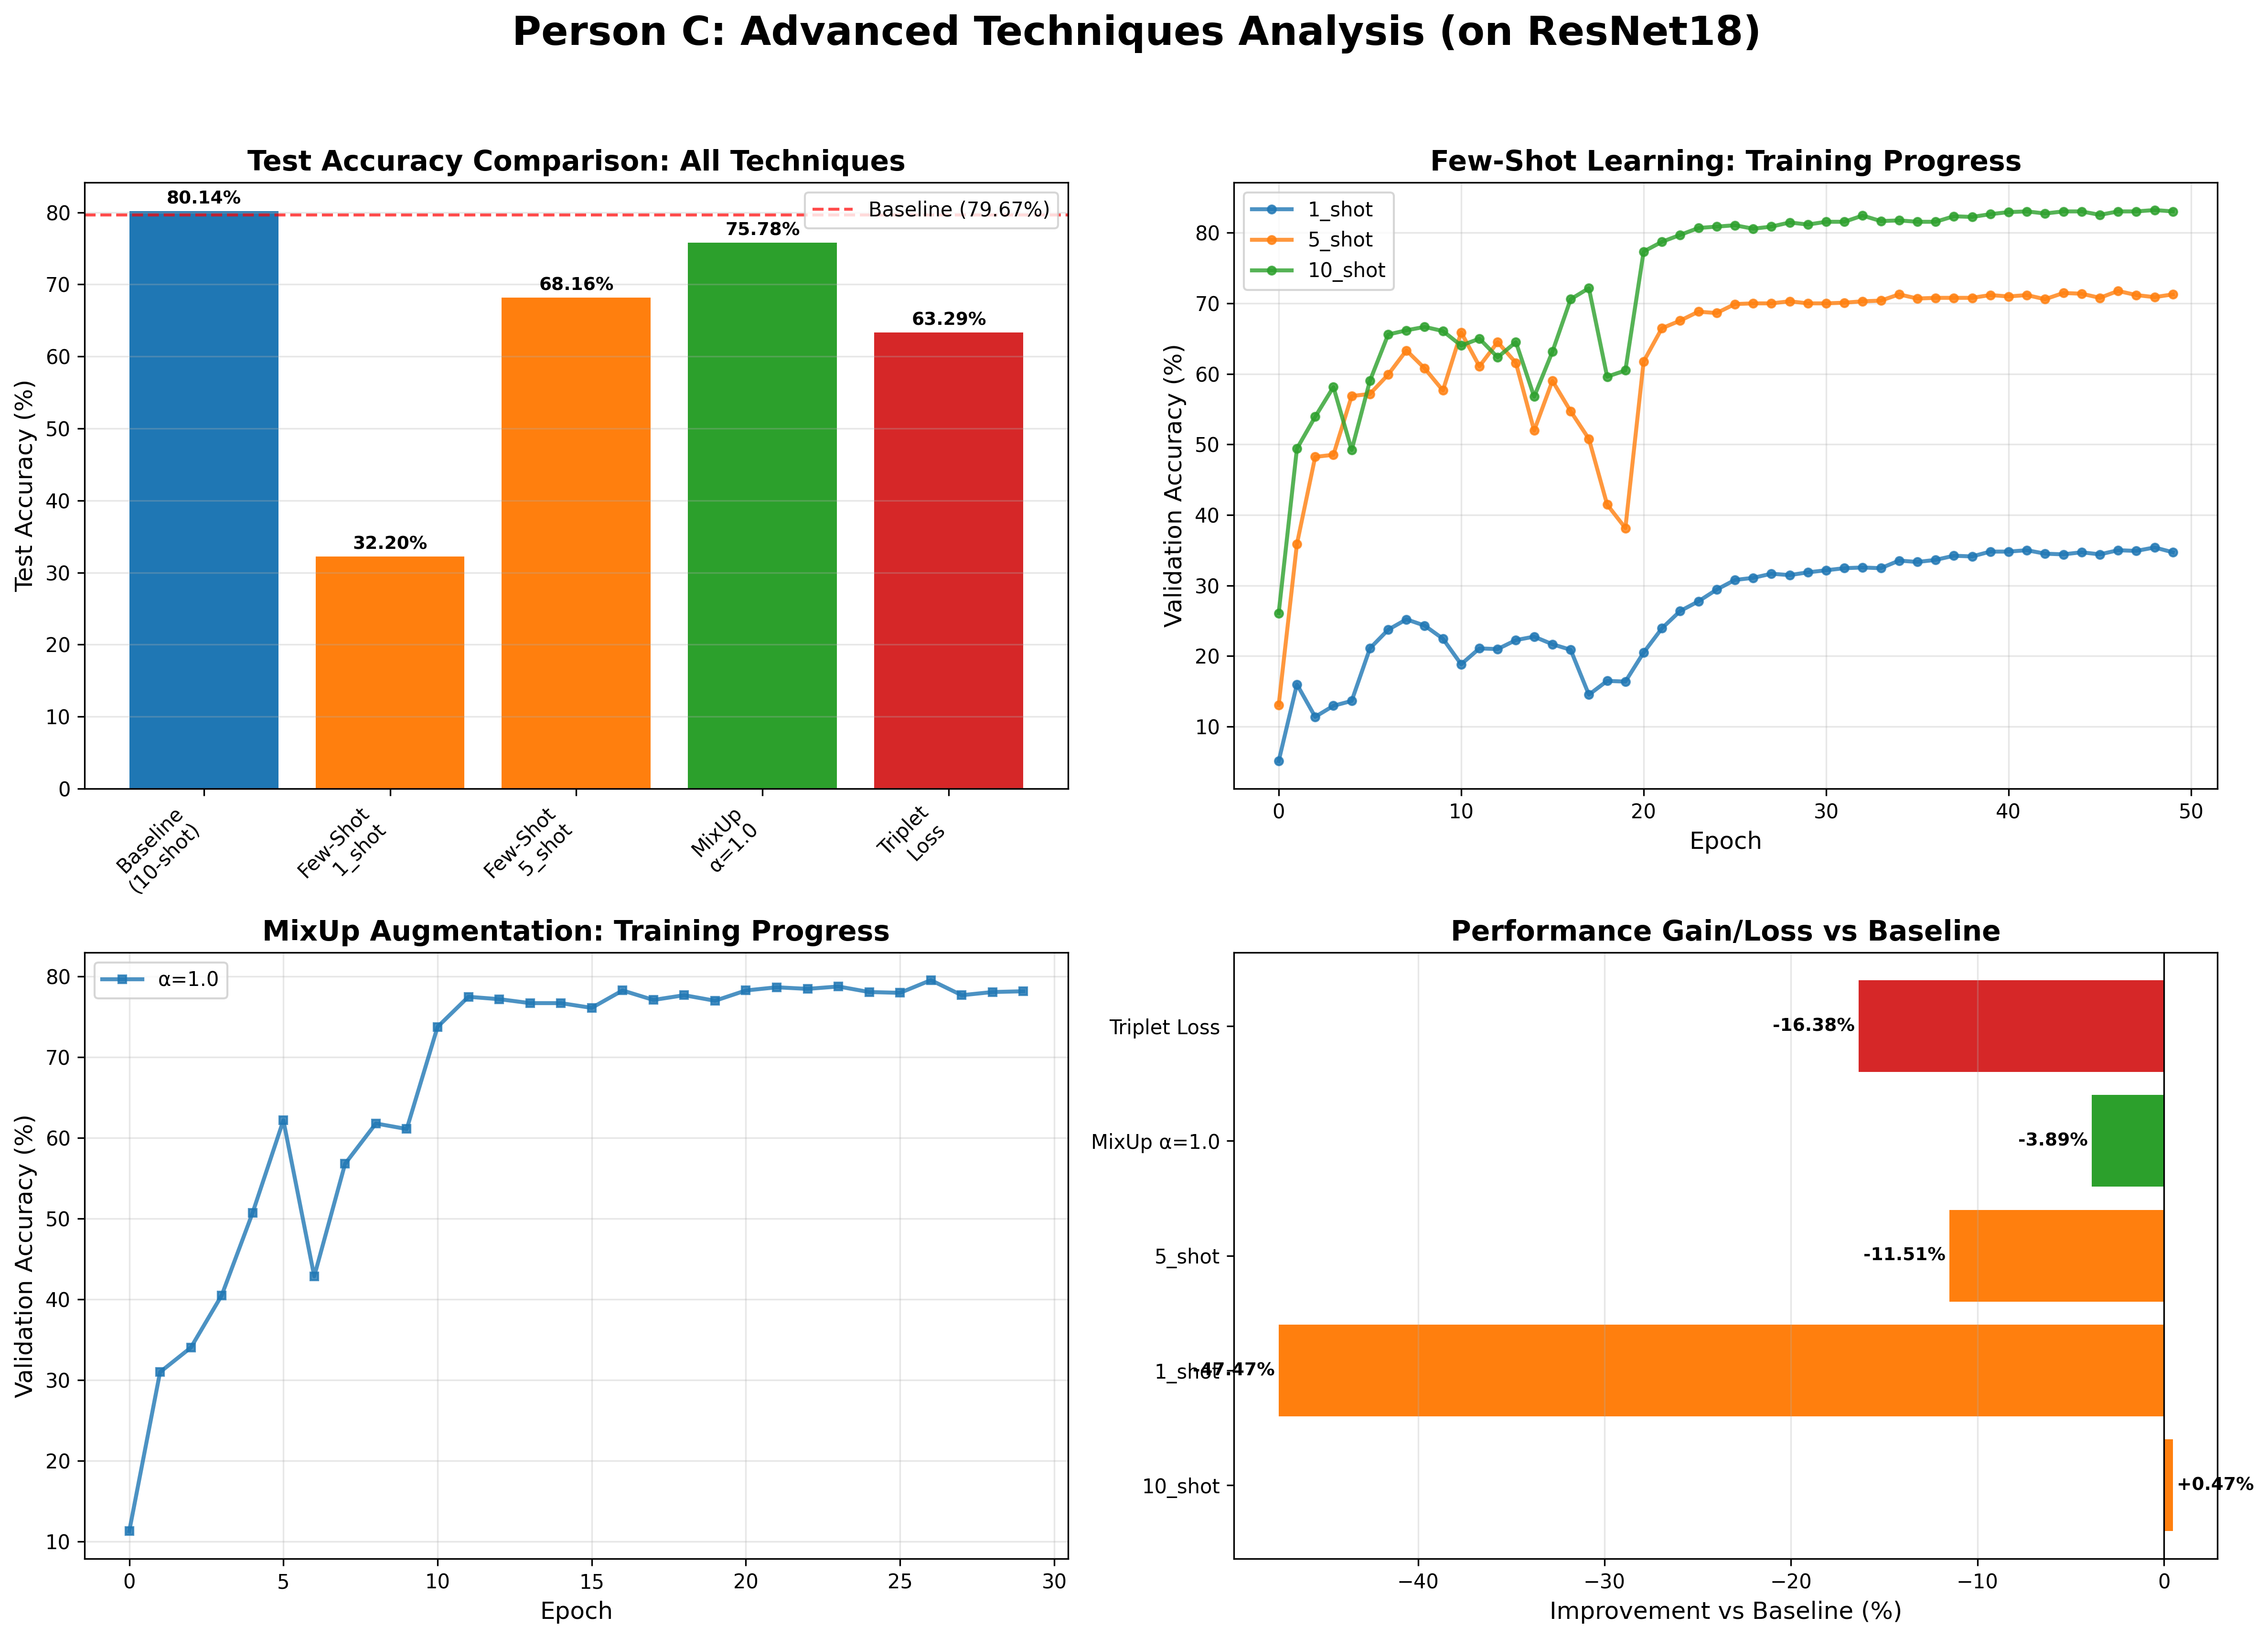
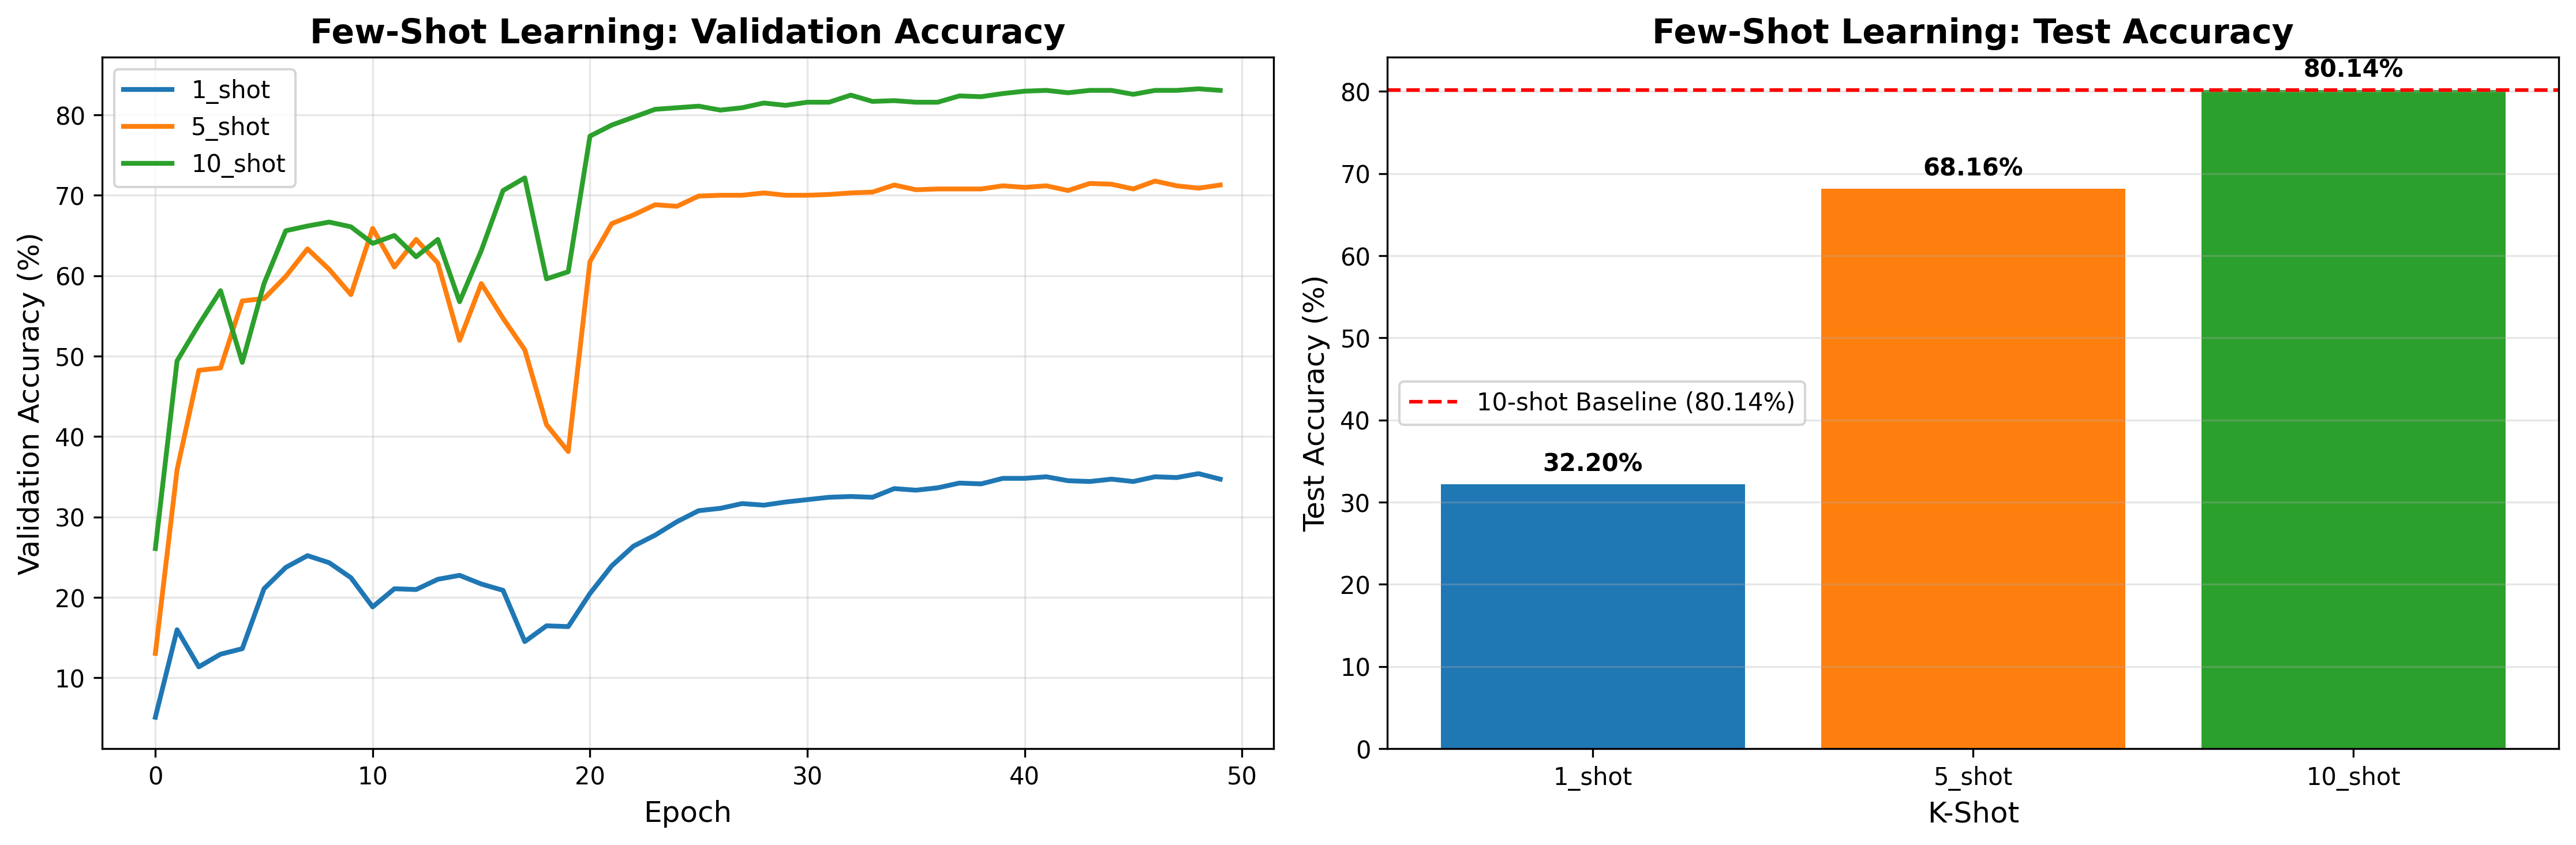
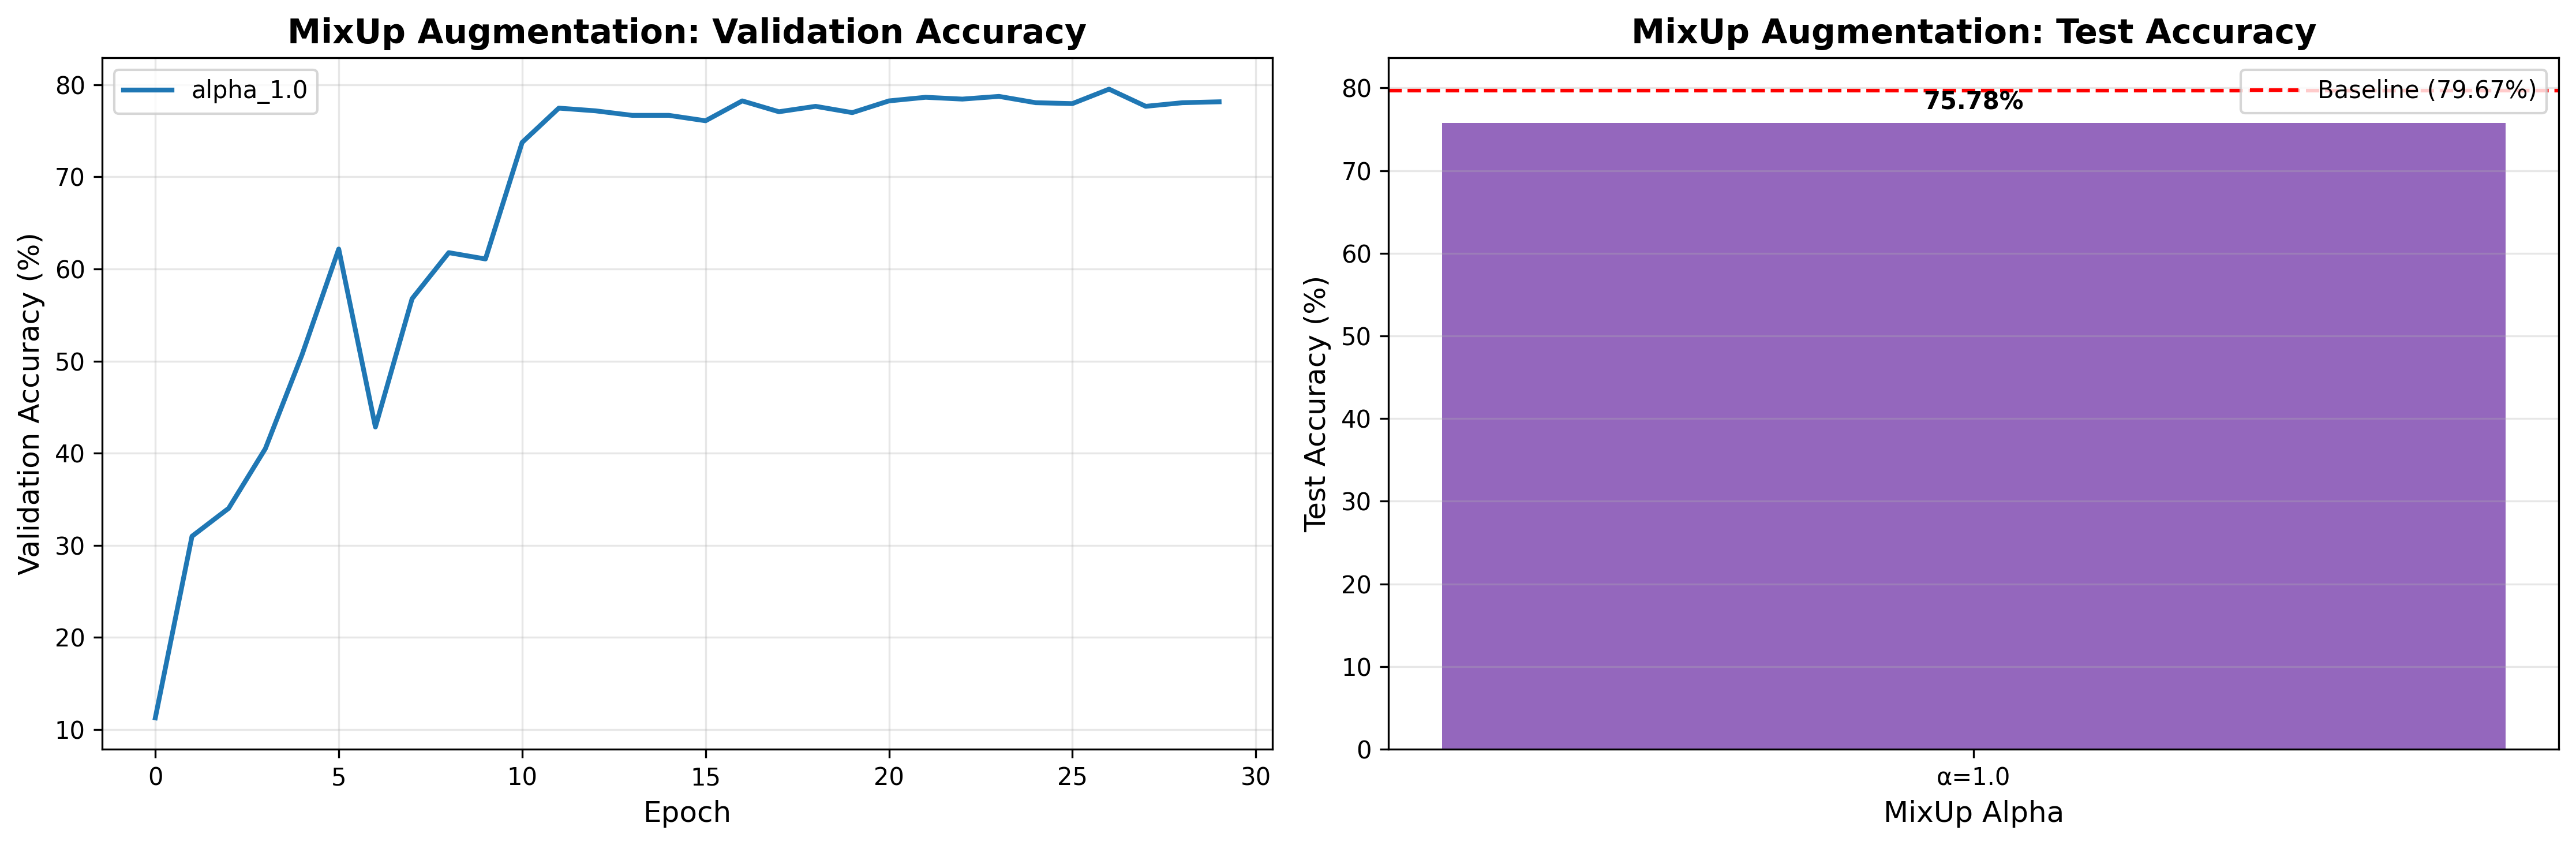

# Combining All